# 1. Setup

In [1]:
!pwd

/home/umni2/a/umnilab/users/verma99/mk/spr_4711/code


In [2]:
from mobilkit.umni import *
from project import *

In [3]:
import osmnx
import yaml

In [4]:
SP.start()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/25 10:29:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/09/25 10:29:24 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


# 2. Prepare data

In [5]:
with open('../data/pois/poi_categories.yml', 'rb') as f:
    poi_categories = yaml.safe_load(f)

poi_classes = []
for source, data in poi_categories.items():
    for cat, fclasses in data.items():
        for fclass in fclasses:
            poi_classes.append((source, cat, fclass))
poi_classes = Pdf(poi_classes, columns=['source', 'category', 'fclass']).disp()

64 rows x 3 cols; Memory: 0.0 MiB


,source,category,fclass
,<object>,<object>,<object>
0,SafeGraph,Education,Elementary and Secondary Schools


## 2.1. OSM

In [6]:
def get_osm_pois(geocode, categories: Pdf, save=True, overwrite=False):
    outfile = Path('../data/pois/osm.parquet')
    if outfile.exists() and not overwrite:
        return SP.read_parquet(outfile)
    fclasses = categories.query('source == "OSM"')['fclass'].unique().tolist()
    df = osmnx.geometries_from_place(geocode, tags={'amenity': fclasses})
    df = df.rename(columns={'amenity': 'fclass'}).to_crs(CRS_M)
    df.geometry = df.centroid
    df = df[['name', 'fclass', 'geometry']].reset_index()
    df = df.rename(columns={'osmid': 'id'}).astype({'id': str})
    df = df.merge(categories, on='fclass').to_crs(CRS_DEG)
    df = df[['id', 'name', 'category', 'fclass', 'geometry']]
    if save:
        df.to_parquet(U.mkfile(outfile))
    return df

osm_pois = get_osm_pois('Indiana', poi_classes, overwrite=0).disp() # t=2:11

+---------+------------+---------+------+--------------------+
|       id|        name| category|fclass|            geometry|
+---------+------------+---------+------+--------------------+
|358649475|Black School|Education|school|[01 01 00 00 00 D...|
+---------+------------+---------+------+--------------------+
only showing top 1 row



## 2.2. SafeGraph

In [7]:
def get_sg_pois(poi_path, pat_path, categories, rgn_code='IN',
                save=True, overwrite=False):
    poi_file = Path('../data/pois/safegraph.parquet')
    od_file = Path('../data/pois/safegraph_patterns.parquet')
    if poi_file.exists() and od_file.exists() and not overwrite:
        return
    poi = SP.read_parquet(poi_path)
    if isinstance(rgn_code, str):
        poi = poi.filter(f'region == "{rgn_code}"')
    poi = poi.select(F.col('placekey').alias('id'), 'name', 'lon', 'lat',
                     F.col('top_category').alias('fclass'), 'area_sqft')
    pat = SP.read_parquet(pat_path).select(*[
        F.col(k).alias(v) for k, v in {
            'placekey': 'id', 'raw_visits': 'visits',
            'raw_visitors': 'visitors', 'visitor_home_cbgs': 'home_bgs'
        }.items()])
    pat = pat.join(poi.select('id'), on='id')
    od = pat.select(F.col('id').alias('poi_id'),
                    F.explode('home_bgs').alias('home_bg', 'visitors'))
    poi = poi.join(pat.drop('home_bgs'), on='id', how='left')
    cats = categories.query('source == "SafeGraph"').drop(columns='source')
    poi = poi.toPandas().merge(cats, on='fclass').drop(columns='fclass')
    poi = mk.geo.pdf2gdf(poi, 'lon', 'lat', CRS_DEG)
    od = od.toPandas().astype({'poi_id': CAT, 'home_bg': CAT})
    if save:
        poi.to_parquet(U.mkfile(poi_file))
        od.to_parquet(U.mkfile(od_file))

poi_path = SAFEGRAPH / 'pois/us/2020-11-06.parquet'
pat_path = SAFEGRAPH / 'patterns/monthly/2020-01-01'
%time x = get_sg_pois(poi_path, pat_path, poi_classes, overwrite=0); x # t=1:03

CPU times: user 1.07 ms, sys: 2.08 ms, total: 3.14 ms
Wall time: 11.4 ms


## 2.3. Combine POIs

In [8]:
def combine_pois(save=True, overwrite=False):
    outfile = Path('../data/pois/pois.parquet')
    if outfile.exists() and not overwrite:
        return SP.read_parquet(outfile)
    osm = gpd.read_parquet('../data/pois/osm.parquet')
    sg = gpd.read_parquet('../data/pois/safegraph.parquet')
    pois = pd.concat([
        osm.assign(source='OSM'), sg.assign(source='SafeGraph')
    ]).reset_index(drop=True)
    if save:
        pois.to_parquet(U.mkfile(outfile))
    return pois

pois = combine_pois(overwrite=0).disp() # t=0:03

+---------+------------+---------+------+--------------------+------+----+----+---------+------+--------+
|       id|        name| category|fclass|            geometry|source| lon| lat|area_sqft|visits|visitors|
+---------+------------+---------+------+--------------------+------+----+----+---------+------+--------+
|358649475|Black School|Education|school|[01 01 00 00 00 D...|   OSM|null|null|     null|  null|    null|
+---------+------------+---------+------+--------------------+------+----+----+---------+------+--------+
only showing top 1 row



# 3. Visualize

In [9]:
pois = gpd.read_parquet('../data/pois/safegraph.parquet').set_crs(CRS_DEG)
areas = pd.concat([
    df.set_index('id').area_sqft.interpolate('linear')
    for _, df in pois.groupby('category')]).reset_index()
pois = pois.drop(columns='area_sqft').merge(areas, on='id').fillna(0).disp()

59,308 rows x 9 cols; Memory: 14.6 MiB; CRS: EPSG:4326


,id,name,lon,lat,visits,visitors,category,geometry,area_sqft
,<object>,<object>,<float32>,<float32>,<float64>,<float64>,<object>,<geometry>,<float64>
0,222-222@5pt-wkp-dqf,Williamsport Day School,-87.28524,40.292946,20.0,11.0,Essential services,POINT (-87.28524 40.292946),7806.0


## 3.1. POI attribute distributions

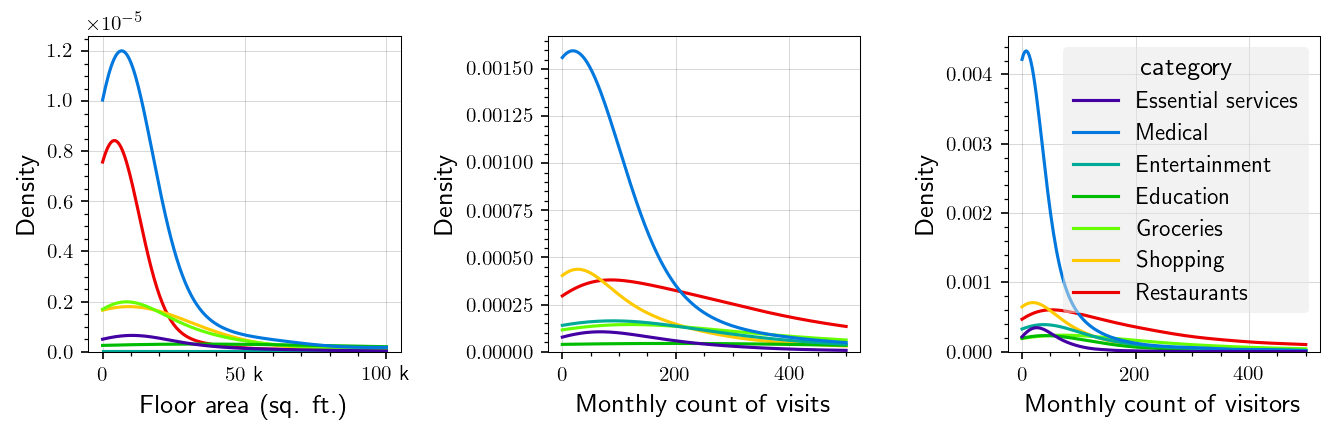

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
for i, (var, label, vmax) in enumerate([
    ('area_sqft', 'Floor area (sq. ft.)', 1e5),
    ('visits', 'Monthly count of visits', 5e2),
    ('visitors', 'Monthly count of visitors', 5e2)
]):
    ax = U.plot(axes[i], xlab=label, xeng=var == 'area_sqft')
    ax = sns.kdeplot(pois, ax=ax, x=var, hue='category', 
                     clip=(0, vmax), palette='nipy_spectral')
    if i != 2: ax.get_legend().remove()
plt.tight_layout()

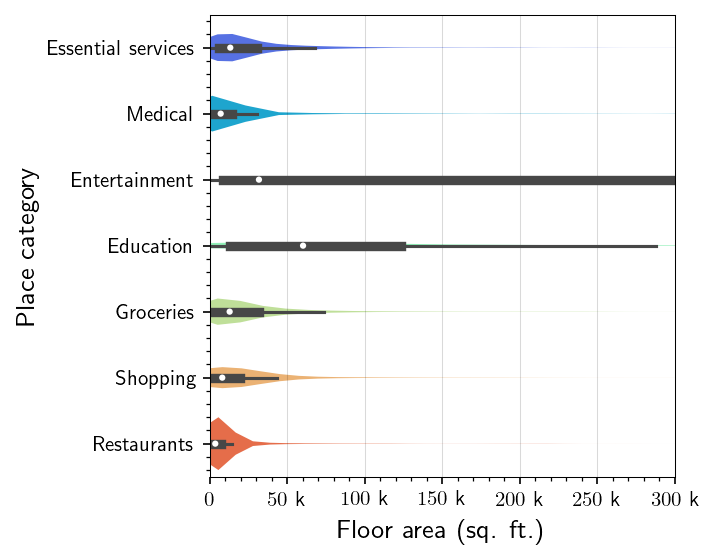

In [11]:
ax = U.plot(size=(4, 4), xlim=(0, 3e5), xeng=1)
sns.violinplot(pois, ax=ax, y='category', x='area_sqft', palette='rainbow')
for x in ax.collections: x.set_edgecolor('none')
U.plot(ax, xlab='Floor area (sq. ft.)', ylab='Place category');

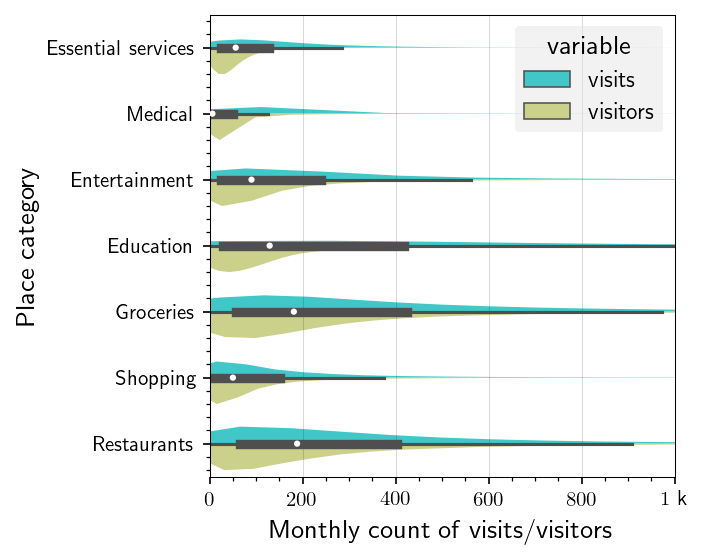

In [12]:
ax = U.plot(size=(4, 4), xlim=(0, 1e3), xeng=1)
sns.violinplot(pois.melt('category', ['visits', 'visitors']),
               ax=ax, y='category', x='value', hue='variable',
               split=True, palette='rainbow')
for x in ax.collections: x.set_edgecolor('none')
U.plot(ax, xlab='Monthly count of visits/visitors', ylab='Place category');